### Group project final report - Exploratory Data Analysis
- Course: CSCI4622                                                                                                   
- Instructor: Yoshinari Fujinuma
- Project title: Predicting Drought Classification Using Weather Data
- Team members: Myeongseon Lee, Vinayak Sharma, Jaskrit Singh, Joshua Sun

### Weather data column index
- fips: US county FIPS code. see: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
- date: observation date
- PRECTOT = Precipitation (mm day-1)
- PS = Surface Pressure (kPa)
- QV2M = Specific Humidity at 2 Meters (g/kg)
- T2M = Temperature at 2 Meters (C)
- T2MDEW = Dew/Frost Point at 2 Meters (C)
- T2MWET = Wet Bulb Temperature at 2 Meters (C)
- T2M_MAX = Maximum Temperature at 2 Meters (C)
- T2M_MIN = Minimum Temperature at 2 Meters (C)
- T2M_RANGE = Temperature Range at 2 Meters (C)
- TS = Earth Skin Temperature (C)
- WS10M = Wind Speed at 10 Meters (m/s)
- WS10M_MAX = Maximum Wind Speed at 10 Meters (m/s)
- WS10M_MIN = Minimum Wind Speed at 10 Meters (m/s)
- WS10M_RANGE = Wind Speed Range at 10 Meters (m/s)
- WS50M = Wind Speed at 50 Meters (m/s)
- WS50M_MAX = Maximum Wind Speed at 50 Meters (m/s)
- WS50M_MIN = Minimum Wind Speed at 50 Meters (m/s)
- WS50M_RANGE = Wind Speed Range at 50 Meters (m/s)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats
from datetime import datetime
%matplotlib inline

### Import data

In [2]:
path = 'data/'  # This is the path to 'data' folder.

In [3]:
soil = pd.read_csv(path+'soil_data.csv')
train=pd.read_csv(path+'train_timeseries.csv')
valid=pd.read_csv(path+'validation_timeseries.csv')
test=pd.read_csv(path+'test_timeseries.csv')

In [7]:
# calculate data percentage
train_data = train.shape[0]
validation_data = valid.shape[0]
test_data = test.shape[0]
total = train_data+test_data+validation_data

print('Train     ',train_data,'', str(round(train_data/total*100,2))+'%')
print('Validation ',validation_data,' ', str(round(validation_data/total*100,2))+'%')
print('Test       ',test_data,' ', str(round(test_data/total*100,2))+'%')
print('Total     ',total,'100.00%')

Train      19300680  80.95%
Validation  2268840   9.52%
Test        2271948   9.53%
Total      23841468 100.00%


### Data preprocessing

In [8]:
# # training data preprocessing
train['date'] = pd.to_datetime(train['date']) # parse date.
train['score'] = train['score'].apply(pd.to_numeric).interpolate()
train['drought_level'] = np.floor(train['score']) # classify drought level.
train.dropna(inplace=True) # remove all examples containing NaN.

# validation data preprocessing
valid['date'] = pd.to_datetime(valid['date']) # parse date.
valid['score'] = valid['score'].apply(pd.to_numeric).interpolate()
valid['drought_level'] = np.floor(valid['score']) # classify drought level.
valid.dropna(inplace=True) # remove all examples containing NaN.

# testing data preprocessing
test['date'] = pd.to_datetime(test['date']) # parse date.
test['score'] = test['score'].apply(pd.to_numeric).interpolate()
test['drought_level'] = np.floor(test['score']) # classify drought level.
test.dropna(inplace=True) # remove all examples containing NaN.

In [9]:
# combined all data set to make one data frame.
all_data = pd.concat([train, valid, test])

In [10]:
train_data = train.shape[0]
validation_data = valid.shape[0]
test_data = test.shape[0]
total = all_data.shape[0]

print('Train     ',train_data,'', str(round(train_data/total*100,2))+'%')
print('Validation ',validation_data,' ', str(round(validation_data/total*100,2))+'%')
print('Test       ',test_data,' ', str(round(test_data/total*100,2))+'%')
print('Total     ',total,'100.00%')

Train      19300677  80.95%
Validation  2268838   9.52%
Test        2271948   9.53%
Total      23841463 100.00%


In [11]:
all_data.head() # check the data

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,drought_level
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.000000,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,1.142857,1.0
5,1001,2000-01-06,0.01,101.31,3.49,4.99,-1.11,-1.07,12.89,-2.96,...,1.55,2.39,0.04,2.35,2.95,5.22,0.05,5.17,1.285714,1.0
6,1001,2000-01-07,0.01,101.37,3.93,5.99,0.55,0.58,14.51,0.63,...,2.31,3.28,1.59,1.69,5.02,6.47,2.44,4.03,1.428571,1.0
7,1001,2000-01-08,1.02,100.77,5.71,8.69,5.33,5.34,15.78,2.74,...,2.05,2.91,1.50,1.40,4.17,5.73,2.01,3.72,1.571429,1.0


### Exploratory Data Analysis 

In [14]:
# Statistical analysis of correlation by Pearson and Spearman methods
for item in all_data.columns:
    if item == 'date':
        pass
    else:
        pearson = stats.pearsonr(train[item], train['score'])
        print(item, 'pearson', pearson)
        spearman = stats.spearmanr(train[item], train['score'])
        print(item, 'spearman', spearman)
        print(' ')

fips pearson (-0.030176063105541308, 0.0)
fips sperman SpearmanrResult(correlation=-0.017978966401279918, pvalue=0.0)
PRECTOT pearson (-0.06131307993258717, 0.0)
PRECTOT sperman SpearmanrResult(correlation=-0.08298863379812477, pvalue=0.0)
PS pearson (-0.18673550874841727, 0.0)
PS sperman SpearmanrResult(correlation=-0.14742560567570573, pvalue=0.0)
QV2M pearson (-0.04529961006037722, 0.0)
QV2M sperman SpearmanrResult(correlation=-0.04473937652912251, pvalue=0.0)
T2M pearson (0.09090046876338906, 0.0)
T2M sperman SpearmanrResult(correlation=0.08885952601017584, pvalue=0.0)
T2MDEW pearson (-0.05212319958033178, 0.0)
T2MDEW sperman SpearmanrResult(correlation=-0.05876204609342879, pvalue=0.0)
T2MWET pearson (-0.05142408933898518, 0.0)
T2MWET sperman SpearmanrResult(correlation=-0.05828381345303609, pvalue=0.0)
T2M_MAX pearson (0.12749967553108857, 0.0)
T2M_MAX sperman SpearmanrResult(correlation=0.1295567399912426, pvalue=0.0)
T2M_MIN pearson (0.061859582499785154, 0.0)
T2M_MIN sperman S

In [17]:
# merge soil_data and all_data 
reduced_data = pd.merge(soil[['fips','lat','lon']], all_data[['fips','date','score','drought_level']], on='fips')

In [18]:
reduced_data['year'] = pd.DatetimeIndex(reduced_data['date']).year # make 'year' column
reduced_data['month'] = pd.DatetimeIndex(reduced_data['date']).month # make 'month' column
reduced_data= reduced_data[['fips','lat','lon','date','year','month', 'score','drought_level']] # re-arange columns


In [31]:
reduced_data_ave = reduced_data.groupby('date').mean() # group by 'date'

In [32]:
# plot = 'plot/' # path for plot files. This is used only when saving plot to file

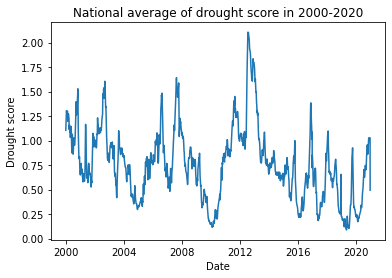

In [33]:
# National average of drought score in 2000-2020
plt.plot(reduced_data_ave['score'])
plt.xlabel('Date')
plt.ylabel('Drought score')
plt.title('National average of drought score in 2000-2020')
# plt.savefig(plot+'National average of drought score in 2000-2020')
plt.show();

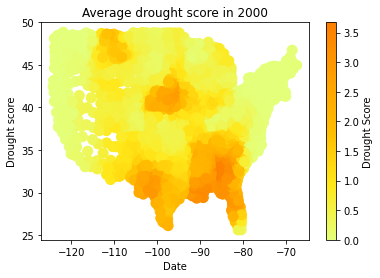

In [34]:
#Average drought score in 2000
year2000 =reduced_data[reduced_data['year']==2000].groupby('fips').mean()

plt.scatter(year2000['lon'], year2000['lat'], c=year2000['score'], cmap=plt.get_cmap('Wistia'), s=100)
cbar = plt.colorbar()
cbar.set_label('Drought Score')
plt.xlabel('Date')
plt.ylabel('Drought score')
plt.title('Average drought score in 2000')
# plt.savefig(plot+'Average drought score in 2000')
plt.show();

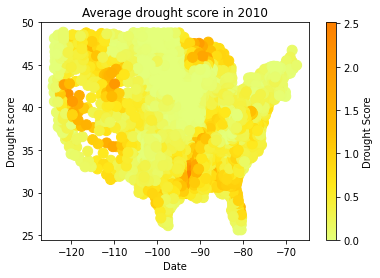

In [35]:
#Average drought score in 2010
year2010 =reduced_data[reduced_data['year']==2010].groupby('fips').mean()
plt.scatter(year2010['lon'], year2010['lat'], c=year2010['score'], cmap=plt.get_cmap('Wistia'), s=100)
cbar = plt.colorbar()
cbar.set_label('Drought Score')
plt.xlabel('Date')
plt.ylabel('Drought score')
plt.title('Average drought score in 2010')
# plt.savefig(plot+'Average drought score in 2010')
plt.show();

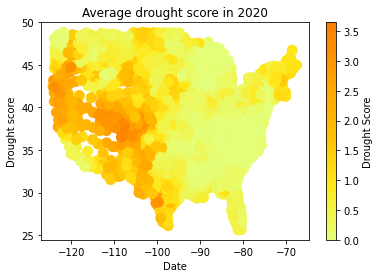

In [36]:
#Average drought score in 2020
year2020 =reduced_data[reduced_data['year']==2020].groupby('fips').mean()
plt.scatter(year2020['lon'], year2020['lat'], c=year2020['score'], cmap=plt.get_cmap('Wistia'), s=100)
cbar = plt.colorbar()
cbar.set_label('Drought Score')
plt.xlabel('Date')
plt.ylabel('Drought score')
plt.title('Average drought score in 2020')
# plt.savefig(plot+'Average drought score in 2020')
plt.show();

In [37]:
# data frame for Boulder analysis
boulder = reduced_data[(reduced_data['fips']==8013)][['date','year','month','score']]

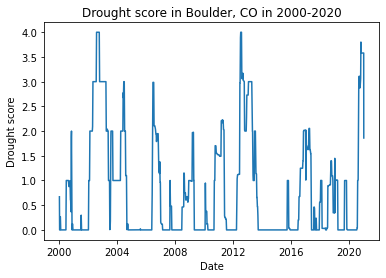

In [38]:
# Average drought score in Boulder, CO
plt.plot(boulder['date'],boulder['score'])
plt.xlabel('Date')
plt.ylabel('Drought score')
plt.title('Drought score in Boulder, CO in 2000-2020')
# plt.savefig(plot+'Drought score in Boulder, CO in 2000-2020-1')
plt.show();

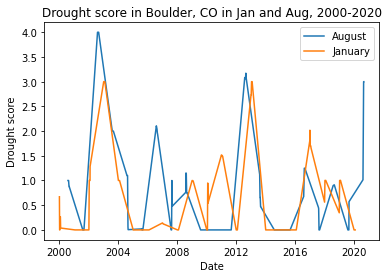

In [39]:
# Drought score in Boulder, CO in Jan and Aug, 2000-2020
boulder_aug = boulder[(boulder['month']==8)]
boulder_jan = boulder[(boulder['month']==1)]

plt.plot(boulder_aug['date'],boulder_aug['score'], label='August')
plt.plot(boulder_jan['date'],boulder_jan['score'], label='January')
plt.xlabel('Date')
plt.ylabel('Drought score')
plt.title('Drought score in Boulder, CO in Jan and Aug, 2000-2020')
plt.legend()
# plt.savefig(plot+'Drought score in Boulder, CO in Jan and Aug, 2000-2020')
plt.show();

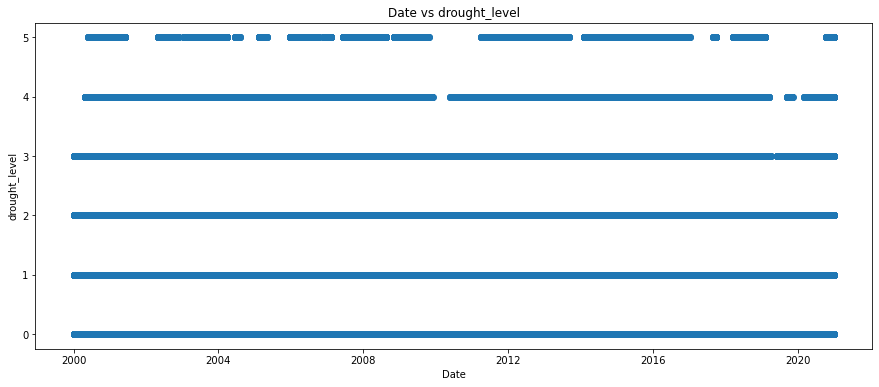

In [40]:
#drought level over time for 20 years.
plt.figure(figsize=(15, 6))
plt.scatter(reduced_data['date'], reduced_data.iloc[:,-1])
plt.title('Date vs ' + reduced_data.columns[-1])
plt.xlabel('Date')
plt.ylabel(reduced_data.columns[-1])
# plt.savefig(plot+'Date vs '+ reduced_data.columns[-1])
plt.show();

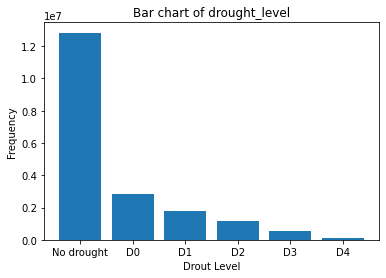

In [41]:
# Bar chart of drought_level
Drout_Level = ['No drought', 'D0', 'D1', 'D2', 'D3', 'D4']
frequency = [np.sum(train['drought_level']==0),
             np.sum(train['drought_level']==1),
             np.sum(train['drought_level']==2),
             np.sum(train['drought_level']==3),
             np.sum(train['drought_level']==4),
             np.sum(train['drought_level']==5)
            ]

plt.bar(Drout_Level, frequency)

plt.title('Bar chart of drought_level')
plt.xlabel('Drout Level')
plt.ylabel('Frequency')
# plt.savefig(plot+'Drout_Level_barchart')
plt.show();

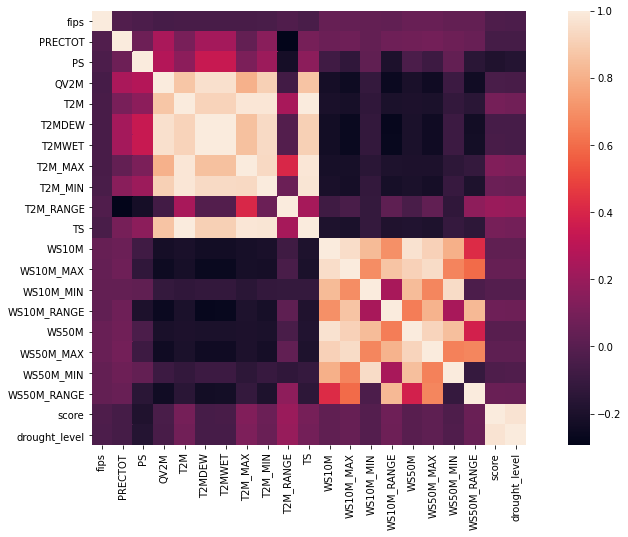

In [42]:
# correlation matrix by seaborn
plt.figure(figsize=(15,8))
sns.heatmap(train.corr(), square=True)#, annot = True)
# plt.savefig(plot+'Correlation of train data set')
plt.show();

In [43]:
# mean value of the major features
grp = train.groupby('drought_level')
grp_stat = grp.describe().iloc[:,[9,17,25,33,41,81,89,121]]
grp_stat

,PRECTOT,PS,QV2M,T2M,T2MDEW,TS,WS10M,WS50M
,mean,mean,mean,mean,mean,mean,mean,mean
drought_level,,,,,,,,
0.0,2.929210,97.294648,8.014350,12.332813,7.430052,12.358831,3.522703,5.510655
1.0,2.223036,95.988509,7.489776,12.921643,6.140979,13.051089,3.621547,5.558429
2.0,2.058162,95.364054,7.304509,13.596210,5.778520,13.825800,3.694386,5.598785
3.0,1.909920,94.405177,7.207713,14.279748,5.517148,14.558533,3.668207,5.550660
4.0,1.854016,94.342378,7.719058,16.095388,6.548991,16.448641,3.595390,5.439555
5.0,1.640568,95.624648,8.222264,18.344232,7.880396,18.805331,3.530004,5.349857


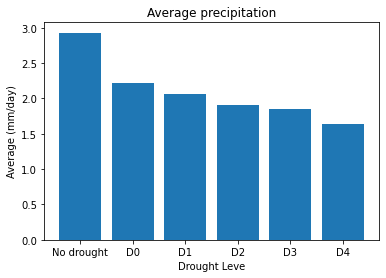

In [44]:
# Mean precipitation of each drougth level
Drout_Level = ['No drought', 'D0', 'D1', 'D2', 'D3', 'D4']
plt.bar(Drout_Level,grp_stat['PRECTOT']['mean'])
plt.title('Average precipitation')
plt.xlabel('Drought Leve')
plt.ylabel('Average (mm/day)')
# plt.savefig(plot+'Mean precipitation of each drougth level')
plt.show();

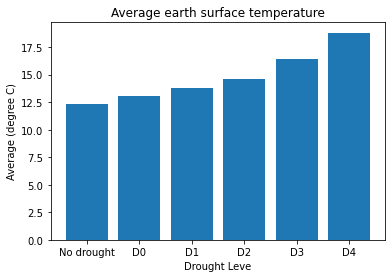

In [45]:
# Mean earth surface temperature
plt.bar(Drout_Level,grp_stat['TS']['mean'])
plt.title('Average earth surface temperature')
plt.xlabel('Drought Leve')
plt.ylabel('Average (degree C)')
# plt.savefig(plot+'Mean earth surface temperature')
plt.show();

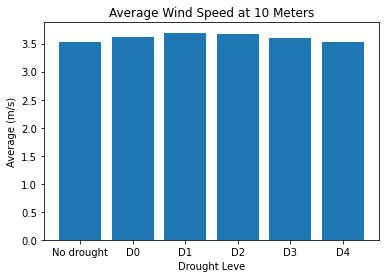

In [46]:
# Mean Wind Speed at 10 Meters
Drout_Level = ['No drought', 'D0', 'D1', 'D2', 'D3', 'D4']
plt.bar(Drout_Level,grp_stat['WS10M']['mean'])
plt.title('Average Wind Speed at 10 Meters')
plt.xlabel('Drought Leve')
plt.ylabel('Average (m/s)')
# plt.savefig(plot+'Mean Wind Speed at 10 Meters')
plt.show();